## De Novo Extraction of Signatures (SigProfilerExtractor re-creation?)
1. Make Matrix M (SBS-96)
2. NMF (loop 100+ times for each k value 1-25)
- M is Poisson resampled, normalized
- initialize NNDSVD (Non-negative double singular value decomposition)
- Minimize objective function based on KL-Divergence; Lee-Sung multiplicative update       
- Hungarian algorithm for clustering (centroids are S matrix)
- Reconstruction: Find average distance to original M
- Stability: silhouette scores
- Plot both^ and find appropriate k
3.  Assess De Novo Signatures match to COSMIC

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyfaidx import Fasta
from sklearn.decomposition import NMF

from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import silhouette_score
from scipy.optimize import nnls

from tqdm import tqdm

## 1. Create M

#### preprocess

In [3]:
df = pd.read_csv("TCGA.STAD.mutations.txt", sep='\t', dtype=str)

# Remove hypermutators (top 1%)
mut_counts = df['patient_id'].value_counts()
cutoff = mut_counts.quantile(0.99)
keep_samples = mut_counts[mut_counts < cutoff].index
df = df[df['patient_id'].isin(keep_samples)]

# # remove genes with less than 10 mutations
# gene_counts = df['Hugo_Symbol'].value_counts()
# keep_genes= gene_counts[gene_counts > 10].index
# df = df[df['Hugo_Symbol'].isin(keep_genes)]

# Keep SNP only
df = df[df['Variant_Type'] == "SNP"]

df = df[['patient_id', 'Chromosome', 'Start_Position', 'Reference_Allele',
         'Tumor_Seq_Allele2', 'Strand']]

#### get tri-nucleotide context

In [4]:
genome = Fasta("hg19.fa")

### Get Trinucleotide context
def get_context(chrom, pos):
    # Adjust for 0-based indexing in pyfaidx
    seq = genome[chrom][pos-2:pos+1].seq.upper()
    return seq

def sbs_category(row):
    ref = row['Reference_Allele']
    alt = row['Tumor_Seq_Allele2']
    chrom = row['Chromosome']
    chrom = f"chr{chrom}"
    pos = int(row['Start_Position'])
    
    try:
        context = get_context(chrom, pos)
    except:
        return None

    # Normalize to C/T as reference
    if ref in ['A', 'G']:
        # Reverse complement
        ref = rev_comp(ref)
        alt = rev_comp(alt)
        context = rev_comp(context)
    
    return f"{context[0]}[{ref}>{alt}]{context[2]}"

def rev_comp(base):
    comp = {'A':'T','T':'A','G':'C','C':'G'}
    return ''.join(comp[b] for b in reversed(base))

df['SBS96'] = df.apply(sbs_category, axis=1)
df = df.dropna(subset=['SBS96'])

## Convert to SBS-96 notation
sbs96_types = sorted(set(df['SBS96']))
samples = sorted(set(df['patient_id']))

M = pd.DataFrame(0, index=sbs96_types, columns=samples)

for _, row in df.iterrows():
    M.loc[row['SBS96'], row['patient_id']] += 1

    
## M is a pd df that has 96 rows and N (samples) columns

In [5]:
M

,TCGA-3M-AB46,TCGA-3M-AB47,TCGA-B7-5816,TCGA-B7-5818,TCGA-B7-A5TI,TCGA-B7-A5TJ,TCGA-B7-A5TK,TCGA-B7-A5TN,TCGA-BR-4187,TCGA-BR-4191,...,TCGA-VQ-AA6A,TCGA-VQ-AA6B,TCGA-VQ-AA6D,TCGA-VQ-AA6F,TCGA-VQ-AA6G,TCGA-VQ-AA6I,TCGA-VQ-AA6J,TCGA-VQ-AA6K,TCGA-ZA-A8F6,TCGA-ZQ-A9CR
A[C>A]A,1,2,2,2,1,1,0,1,0,1,...,1,2,2,1,0,1,2,0,0,1
A[C>A]C,2,2,2,2,0,2,1,0,0,2,...,1,0,0,1,0,0,0,1,0,3
A[C>A]G,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
A[C>A]T,1,2,0,2,2,0,0,2,0,2,...,2,0,2,0,1,0,3,1,0,0
A[C>G]A,1,0,3,1,1,0,0,1,0,0,...,1,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T[T>C]T,0,0,5,2,4,2,1,0,0,1,...,0,0,4,3,3,0,1,0,0,0
T[T>G]A,1,1,0,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
T[T>G]C,0,0,0,3,1,1,0,0,0,2,...,0,1,2,1,0,0,0,0,0,0
T[T>G]G,0,0,1,2,0,0,0,2,0,2,...,1,1,1,1,0,0,1,0,0,1


## 2. Create functions for:
- Poisson resampling, normalizing 
- running & repeating nmf (NNDSVD initialization, KL-divergence Lee-Sung multiplicative update)
- clustering (Hungarian algorithm)
- silhouette & reconstruction calculations

In [6]:
def poisson_resample(M):
    return np.random.poisson(lam=M)

def normalize_columns(M):
    # old normalization
    # M_norm = M / (M.sum(axis=0, keepdims=True) + 1e-9)

    # log2 normalization (as described by paper)
    M = np.asarray(M)
    M_norm = M.copy()
    col_sums = M.sum(axis=0)
    log2_sums = np.log2(col_sums + 1e-9)  # prevent log(0)
    factors = log2_sums / (col_sums + 1e-9)
    M_norm = M * factors  # broadcasts per column

    return M_norm

def run_kl_nmf(M, k, max_iter):
    model = NMF(n_components=k,
                init='nndsvd',
                solver='mu',
                beta_loss='kullback-leibler',
                max_iter=max_iter,
                random_state=None)
    W = model.fit_transform(M)
    H = model.components_
    loss = model.reconstruction_err_
    return W, H, loss

def repeated_kl_nmf(M, k, n_runs, nmf_iter):
    W_list, H_list, loss_list = [], [], []
    for _ in range(n_runs):
        M_poisson = poisson_resample(M)
        M_norm = normalize_columns(M_poisson)
        try:
            W, H, loss = run_kl_nmf(M_norm, k, nmf_iter)
            W_list.append(W)
            H_list.append(H)
            loss_list.append(loss)
        except:
            continue  # catch factorization errors
    return W_list, H_list, loss_list


In [7]:
# used to reconstruct the activity matrix from the centroid (as best as possible, using NNL)
def solve_activities(M, S):
    """
    Solve for A in M ≈ S * A using nonnegative least squares.
    M: [96 x N] mutation matrix
    S: [96 x k] consensus signatures
    Returns A: [k x N] activity matrix
    """
    k = S.shape[1]
    N = M.shape[1]
    A = np.zeros((k, N))

    for i in range(N):
        A[:, i], _ = nnls(S, M[:, i])

    return A

# Performs hungarian clustering (trying to emulate SigProfilerExtractor) to isolate signature matrix (each column vector of S is a centroid)
def hungarian_clustering(W_list, k, max_iter, tol=1e-4):
    """
    Performs consensus clustering of signature matrices using the Hungarian algorithm.
    
    Parameters:
        W_list: list of 100 signature matrices (each [96 x k])
        k: number of signatures
        max_iter: max number of iterations
        tol: silhouette score convergence threshold
        
    Returns:
        centroids: [96 x k] consensus mutational signatures
        stability: silhouette score of cluster assignments
    """
    S_all = np.stack(W_list)  # [100, 96, k]
    n_runs = S_all.shape[0]

    # Reshape to list of all 100k signature vectors
    sig_vecs = np.concatenate([S_all[i] for i in range(n_runs)], axis=1).T  # shape: [100*k, 96]
    
    # Random init centroids
    centroids = sig_vecs[np.random.choice(sig_vecs.shape[0], k, replace=False)]

    prev_silhouette = -2

    for _ in range(max_iter):
        assignments = [[] for _ in range(k)]  # signatures assigned to each cluster

        for i in range(n_runs):
            cost = -cosine_similarity(S_all[i].T, centroids)  # shape: [k x k]
            _, col_assign = linear_sum_assignment(cost)
            for col_idx, assigned in enumerate(col_assign):
                assignments[assigned].append(S_all[i][:, col_idx])

        new_centroids = np.array([np.mean(cluster, axis=0) for cluster in assignments])  # shape: [k, 96]
        new_centroids = np.nan_to_num(new_centroids)  # handle possible empty clusters

        # Recompute silhouette score
        all_vectors = np.vstack([v for cluster in assignments for v in cluster])
        cluster_labels = np.concatenate([[i] * len(cluster) for i, cluster in enumerate(assignments)])
        silhouette = silhouette_score(all_vectors, cluster_labels, metric='cosine')

        if abs(silhouette - prev_silhouette) < tol:
            break

        centroids = new_centroids
        prev_silhouette = silhouette

    return centroids.T, silhouette  # Return shape [96 x k], stability score

## 4. Iterate over all k-values

In [8]:
import warnings
warnings.filterwarnings('ignore') # because I don't wanna see this in the output when I have a progress bar lol

# Adjust these numbers when debugging for time's sake
n_runs = 100 # number of times NMF is repeated for each k
nmf_iter = 1000 # maximum iterations for a given factorization
hungarian_iter = 100 # maximum iterations for hungarian clustering
tol = 10e-4 # tolerance for hungarian clustering

# Loop performing NMF for al values of K
ks = range(2, 25)

# Tracking these metrics for each k
avg_errors = []
recon_errors = []
stabilities = []

# Store signatures for each k-value
S_matrices = {}    # or S_list = []
A_matrices = {}    # or A_list = []
M_stars     = {}   # or M_star_list = []

M_array = np.asarray(M) # creat np array form of df

for k in tqdm(ks):
    S, A, loss = repeated_kl_nmf(M, k, n_runs, nmf_iter)
    avg_errors.append(np.mean(loss))

    # Do dimensionality reduction & clustering with factorizations (S matrix only)
    centroids, silhouette = hungarian_clustering(S, k, hungarian_iter, tol) 
        # centroids collectively represent S matrix

    # average Reconstruction error
    A = solve_activities(M_array, centroids)
    M_star = np.dot(centroids, A)
    recon_error = np.mean(cosine_distances(M_array.T, M_star.T))

    # Store values for plotting later
    recon_errors.append(recon_error)
    stabilities.append(silhouette)

    # Save S (centroids), A, M* for future use
    S_matrices[k] = centroids           # S = centroids, shape: [96 x k]
    A_matrices[k] = A                   # Activities, shape: [k x N]
    M_stars[k]     = M_star             # Reconstructed M*, shape: [96 x N]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [02:09<00:00,  5.64s/it]


### Plot avg stability and reconstruction for each k-value

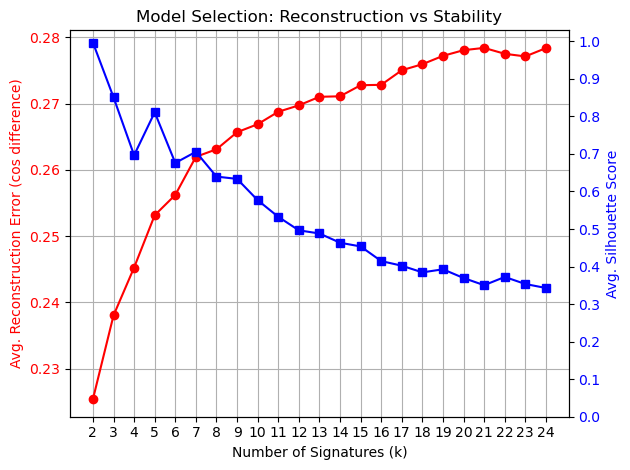

In [9]:
fig, ax1 = plt.subplots()

# Left y-axis: Reconstruction error
ax1.plot(ks, recon_errors, 'ro-', label='Reconstruction Error')  # red line with dots
ax1.set_xlabel("Number of Signatures (k)")
ax1.set_ylabel("Avg. Reconstruction Error (cos difference)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(ks)  # more x-axis ticks at each k
ax1.grid(True)

# Right y-axis: Silhouette score (stability)
ax2 = ax1.twinx()
ax2.plot(ks, stabilities, 'bs-', label='Silhouette Score')  # blue line with dots
ax2.set_ylabel("Avg. Silhouette Score", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_yticks(np.linspace(0, 1, 11))  # optional: more y ticks for stability axis

plt.title("Model Selection: Reconstruction vs Stability")
fig.tight_layout()
plt.show()

reconstruction error increases with # signatures, would expect opposite trend?

### Compare M and M* and distributions of SBS-96 types

In [13]:
SBS_types = M.columns.tolist()

# Convert mutation counts to percentages
sbs_counts = np.sum(M_array,1) 
sbs_percent = sbs_counts/np.sum(sbs_counts,0) 

reconstruction_counts = np.sum(M_array,1) 
reconstruction_percent = reconstruction_counts/np.sum(reconstruction_counts,0) 





### Compare distribution of SBS-96 mut types for each signature (k signatures), calculate % match to 'known' cosmic signatures

In [ ]:
# cosmic signature columns (sbs-type x signature) sum to one (they are percentages of base substitutions)
cosmic = pd.read_csv("COSMIC_v3.4_SBS_GRCh37.txt", sep='\t', dtype=str)

def match_signatures(S_de_novo, S_cosmic):
    return cosine_similarity(S_de_novo.T, S_cosmic.T), nnls(S_de_novo, S_cosmic)

### metadata matching?

## Run/Compare to other NMF methods
* Signature Analyzer, SigProfilerExtractor, SigProfiler PCAWG, Tensor Signatures (Python options from paper)